In [64]:
#! R

##import kallisto, make Poisson heatmap plot and PCA
##load libraries
libs <- c("sleuth","tidyverse","ggrepel","biomaRt","pheatmap","RColorBrewer","PoiClaClu","DESeq2","rhdf5","ggplot2","devtools","cowplot", "reshape2", "limma", "edgeR", "DESeq2")
libsLoaded <- lapply(libs,function(l){suppressWarnings(suppressMessages(library(l, character.only = TRUE)))})

##input parameters
BASEDIR <- "../"
DATADIR <- paste0(BASEDIR, "/analysis/RNAseq")
OUTDIR <- paste0(DATADIR, "/kallisto-sleuth_full")
SHARDATADIR <- paste0(BASEDIR, "/analysis/RNAseq/shared_RData")
RDATADIR <- paste0(OUTDIR, "/RData")
dir.create(RDATADIR, showWarnings=FALSE, recursive=TRUE)
dir.create(SHARDATADIR, showWarnings=FALSE, recursive=TRUE)

CLIN <- "rdl_RNAseq.metadata.tsv"
metadata <- read_tsv(CLIN) %>%
                   dplyr::filter(! sampleID %in% c("S2","S12")) %>%
                   dplyr::mutate(path = file.path(DATADIR, sampleID, "kallisto", "abundance.h5")) %>%
                   dplyr::rename("sample" = sampleID)

##source plotting functions
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/poissonHeatmap.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/sleuth/plot_expression_sleuth.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/pcaPlot.func.R")

##input parameters for loading sleuth data
memfree <- as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
ramPerCoreGB <- 15
threadAlloc <- round((memfree/1000000)/ramPerCoreGB, 0)-1

Parsed with column specification:
cols(
  sampleID = col_character(),
  Individual = col_double(),
  Tissue = col_character(),
  Diet = col_character(),
  Intervention = col_character(),
  Batch = col_character()
)



In [65]:
##rat-human annotation
OUTPUT <- paste0(SHARDATADIR, "/tx2gene.gene2ext.human_rat_intersect_anno.RData")
if(!file.exists(OUTPUT)){
    RGENOME <- "rnorvegicus_gene_ensembl"
    HGENOME <- "hsapiens_gene_ensembl"
    rmart <- biomaRt::useMart(biomart = "ensembl", dataset = RGENOME)
    hmart <- biomaRt::useMart(biomart = "ensembl", dataset = HGENOME)

    tx2gene <- biomaRt::getBM(attributes=c("ensembl_transcript_id", "ensembl_gene_id", "external_gene_name"), mart = hmart)
    colnames(tx2gene)[1] <- "target_id"
    hgene2ext <- biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)

    rtx2gene <- as_tibble(biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = rmart)) %>%
                dplyr::arrange(external_gene_name) %>%
                dplyr::mutate(human_external_gene_name = toupper(external_gene_name))
    htx2gene <- as_tibble(biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)) %>%
                dplyr::arrange(external_gene_name) %>%
                dplyr::rename(human_external_gene_name = "external_gene_name")
    rhtx2gene <- inner_join(rtx2gene, htx2gene, by="human_external_gene_name")
    rhtx2gene <- rhtx2gene %>% dplyr::rename(ensembl_gene_id = "ensembl_gene_id.x", human_ensembl_gene_id = "ensembl_gene_id.y")
    save(rtx2gene, htx2gene, hgene2ext, rhtx2gene, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [66]:
##read sleuth inputs
OUTPUT <- paste0(RDATADIR, "/rdl_RNAseq.sleuthObject.RData")
if(!file.exists(OUTPUT)){
    h5closeAll()
    so <- sleuth_prep(metadata,
                      full_model =~ Tissue + Diet + Batch,
                      target_mapping = rtx2gene,
                      aggregation_column = "ensembl_gene_id", 
                      gene_mode = TRUE,
                      num_cores = threadAlloc,
                      max_bootstrap = 50)
    save(so, metadata, file=OUTPUT)
    syscall <- paste0("md5sum ", OUTPUT, " > ", paste0(RDATADIR, "/rdl_RNAseq.sleuthObject.md5sum")")
    system(syscall)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [4]:
##find 'true normal' tissue, i.e. from rats never devloping 

In [67]:
##counts from gene_mode (non-integer) sleuth object
OUTPUT <- paste0(RDATADIR, "/obs_norm_filt_df.conds.all.RData")
if(!file.exists(OUTPUT)){

    ##create DF
    obs_norm_filt_df <- dcast(so$obs_norm_filt, 
                              target_id ~ sample, 
                              value.var="scaled_reads_per_base") %>% 
                        dplyr::rename("ensembl_gene_id" = target_id) %>%
                        dplyr::arrange(ensembl_gene_id) %>%
                        dplyr::mutate_if(is.numeric, round, 0) %>%
                        as.data.frame() %>%
                        column_to_rownames(., var="ensembl_gene_id")
    
    ##input conditions
    conds <- metadata %>% dplyr::select(sample, Individual, Tissue, Intervention, Diet, Batch) %>% as.data.frame() 
    conds[] <- lapply(conds, factor)
  
    save(obs_norm_filt_df, conds, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}



In [68]:
##distribution of log(scaled_reads_per_base) to filter low expression
OUTPUT <- paste0(RDATADIR, "/obs_norm_filt2_df.conds.RData")
if(!file.exists(OUTPUT)){
    
    ##v. similar distribution for Tissue, Batch and other factors
    ##indciates log(3) as cutoff generally, =~20 scaled_reads_per_base
    samplet <- conds$sample[conds$Tissue=="Tumour"]
    sot <- so$obs_norm_filt %>% dplyr::filter(sample %in% samplet)
    samplen <- conds$sample[conds$Tissue=="Normal"]
    son <- so$obs_norm_filt %>% dplyr::filter(sample %in% samplen)

    ggp <- ggplot() + 
           geom_density(data=son, aes(log(scaled_reads_per_base), colour="Tumour")) +
           geom_density(data=sot, aes(log(scaled_reads_per_base), colour="Normal")) +
           xlim(c(-0.5,11))

    ##filter obs_norm_filt_df
    print(paste0("Sleuth filtered: ", dim(obs_norm_filt_df), " genes"))
    obs_norm_filt2_df <- as_tibble(obs_norm_filt_df, 
                                    rownames="ensembl_gene_id") %>% dplyr::mutate(mean = rowMeans(dplyr::select_if(., is.numeric))) %>%
                                                                    dplyr::filter(mean > 20) %>% 
                                                                    dplyr::select(-mean) %>%
                                                                    column_to_rownames("ensembl_gene_id")
    print(paste0("Density filtered: ", dim(obs_norm_filt2_df), " genes"))

    save(sot, son, obs_norm_filt2_df, conds, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [69]:
##limma-voom including duplicateCorrelation as multiple Individuals have several replicates
OUTPUT <- paste0(RDATADIR, "/limma-voom.DGEList-corfit.RData")
if(!file.exists(OUTPUT)){
    
    ##make input model.matrix design
    mmdf <- data.frame(Contrasts=paste(conds$Tissue, conds$Diet, conds$Intervention, sep="."),
                       Batch=conds$Batch)
    all.design <- model.matrix(~0 + Contrasts + Batch, data = mmdf)
    colnames(all.design) <- c(levels(mmdf$Contrasts), "Batch")
    
    ##make DGEList from filtered counts
    all.dge <- DGEList(counts=obs_norm_filt2_df)
    all.keep <- filterByExpr(all.dge, 
                             all.design)
    all.dge <- all.dge[all.keep, 
                       keep.lib.sizes=FALSE]
    all.dge <- calcNormFactors(all.dge, 
                               method="TMM")
    
    ##voom, with 2 rounds of dupcor
    all.voom <- voom(all.dge, 
                     all.design, 
                     plot = FALSE)
    all.cor <- duplicateCorrelation(all.voom, 
                                    block = conds$Individual)
    print(paste0("Duplicate correlation 1: ", all.cor$consensus.correlation))
    all.voom1 <- voom(all.dge, 
                      all.design, 
                      plot = FALSE, 
                      correlation = all.cor$consensus.correlation, block=conds$Individual)
    all.cor1 <- duplicateCorrelation(all.voom1, 
                                     block = conds$Individual)
    print(paste0("Duplicate correlation 2: ", all.cor1$consensus.correlation))

    ##fit
    all.fit <- lmFit(all.voom1, 
                     all.design, 
                     block = conds$Individual, 
                     correlation = all.cor1$consensus.correlation)
    
    save(mmdf, all.design, all.voom1, all.cor1, all.fit, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

In [70]:
##contrasts applied to tumour, normal across desired comparisons
OUTPUT <- paste0(RDATADIR, "/limma-voom.contrastList.RData")
if(!file.exists(OUTPUT)){

    cont.matrix <- makeContrasts(
        t_Diet_HFD_vs_NC=Tumour.HFD.NO-Tumour.NC.NO,
        t_Int_LIR_vs_NO=Tumour.HFD.LIR-Tumour.HFD.NO,
        t_Int_RES_vs_NO=Tumour.HFD.RES-Tumour.HFD.NO,
        t_Int_LIR_vs_RES=Tumour.HFD.LIR-Tumour.HFD.RES,
        n_Diet_HFD_vs_NC=Normal.HFD.NO-Normal.NC.NO,
        n_Int_LIR_vs_NO=Normal.HFD.LIR-Normal.HFD.NO,
        n_Int_RES_vs_NO=Normal.HFD.RES-Normal.HFD.NO,
        n_Int_LIR_vs_RES=Normal.HFD.LIR-Normal.HFD.RES,
        levels=all.design)
    all.fit2 <- contrasts.fit(all.fit, cont.matrix)
    all.fite <- eBayes(all.fit2, robust=TRUE)
    contrastList <- as.list(1:8)
    contrastList[[1]] <- topTable(all.fite, number=Inf, coef="Diet_HFD_vs_NC")
    contrastList[[2]] <- topTable(all.fite, number=Inf, coef="Int_LIR_vs_NO")
    contrastList[[3]] <- topTable(all.fite, number=Inf, coef="Int_RES_vs_NO")
    contrastList[[4]] <- topTable(all.fite, number=Inf, coef="Int_LIR_vs_RES")
    contrastList[[5]] <- topTable(all.fite, number=Inf, coef="nDiet_HFD_vs_NC")
    contrastList[[6]] <- topTable(all.fite, number=Inf, coef="nInt_LIR_vs_NO")
    contrastList[[7]] <- topTable(all.fite, number=Inf, coef="nInt_RES_vs_NO")
    contrastList[[8]] <- topTable(all.fite, number=Inf, coef="nInt_LIR_vs_RES")
    names(contrastList) <- c("t_Diet_HFD_vs_NC", 
                             "t_Int_LIR_vs_NO", 
                             "t_Int_RES_vs_NO", 
                             "t_Int_LIR_vs_RES",
                             "n_Diet_HFD_vs_NC", 
                             "n_Int_LIR_vs_NO", 
                             "n_Int_RES_vs_NO", 
                             "n_Int_LIR_vs_RES")
    save(cont.matrix, all.fit2, all.fite, all.cor1, contrastList, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [71]:
##iterate over contrastList, find those with DE
OUTPUT <- paste0(RDATADIR, "/limma-voom.DEList.RData")
if(!file.exists(OUTPUT)){
    DEList <- lapply(seq_along(contrastList),function(f){
        dimcl <- as_tibble(contrastList[[f]], rownames="ensembl_gene_id") %>% 
                    inner_join(gene2ext,.) %>% 
                    dplyr::filter(adj.P.Val < 0.1) %>%
                    dplyr::select(ensembl_gene_id, external_gene_name, logFC, adj.P.Val) %>%
                    dplyr::mutate_if(is.numeric, round, 3) %>%
                    dplyr::arrange(desc(logFC))
        if(dim(dimcl)[1] > 0){
            return(dimcl)
        }
    })
    names(DEList) <- names(contrastList)
    DEList <- DEList[!sapply(DEList, is.null)]
    lapply(seq_along(DEList), function(f){
        write_excel_csv(x=DEList[[f]], 
                        path=paste0(OUTDIR, "/", names(DEList)[f],".DE.csv"),
                        col_names=TRUE,,
                        append=FALSE)
    })
    save(DEList, file=OUTPUT)

}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}
lapply(DEList,dim)


$t_Diet_HFD_vs_NC
[1] 383   4

$t_Int_LIR_vs_RES
[1] 54  4

$n_Int_LIR_vs_NO
[1] 33  4

$n_Int_LIR_vs_RES
[1] 162   4

In [72]:
##volcano, MA plots for contrastList with elements
coef.vec <- names(DEList)
coef.ind <- c(1, 4, 6, 8)
deVec <- c(1:4)

all.fite$names <- as_tibble(all.fite$coefficients, rownames="ensembl_gene_id") %>% 
          left_join(., rhtx2gene) %>% 
          dplyr::select(-human_ensembl_gene_id) %>% 
          unique() %>% 
          dplyr::select(external_gene_name) %>% 
          unlist()       

pv1 <- function(f){
if(f<0.1){
    return("Y")
}
else{
    return("N")
}}

volcanoMAplotList <- lapply(seq_along(coef.ind), function(x){

    clx <- as_tibble(contrastList[[coef.ind[x]]], rownames="rn") %>% 
           dplyr::arrange(rn) %>% 
           dplyr::mutate(HL = unlist(lapply(adj.P.Val, pv1))) %>% 
           dplyr::select(rn, HL) %>% column_to_rownames("rn") %>% 
           unlist()

    pdf(paste0(OUTDIR, "/volcanoMAplot.", coef.vec[x], ".pdf"))
        volcanoplot(all.fite, coef = coef.ind[x], 
                    style = "p-value", hl.col="red",
                    highlight = dim(DEList[[x]])[1], 
                    xlab = "Log2 Fold Change", ylab = NULL, 
                    pch=16, cex=0.35, names=all.fite$names)
        plotMA(all.fite, coef = contVec[x], 
                hl.col="red", pch=16, cex=0.35,
               xlab = "Log2 Fold Change", ylab = "Expression log-ratio", 
               status=clx)
    dev.off()
})



Joining, by = "ensembl_gene_id"


Joining, by = "ensembl_gene_id"


       ensembl_gene_id external_gene_name  logFC adj.P.Val
1   ENSRNOG00000048421     AABR07012079.1  3.411     0.030
2   ENSRNOG00000053343         AC098459.2  2.353     0.059
3   ENSRNOG00000040153       LOC108348062  2.320     0.058
4   ENSRNOG00000033915                Gpt  1.841     0.044
5   ENSRNOG00000022101             Crabp2  1.799     0.085
6   ENSRNOG00000016690               Idi1  1.772     0.058
7   ENSRNOG00000012390                Npw  1.770     0.078
8   ENSRNOG00000049150     AABR07045621.1  1.728     0.092
9   ENSRNOG00000020389             Capn12  1.703     0.051
10  ENSRNOG00000010265                Ada  1.452     0.078
11  ENSRNOG00000013825            Rap1gap  1.347     0.058
12  ENSRNOG00000028883     AABR07072078.1  1.328     0.058
13  ENSRNOG00000018029              Doc2g  1.039     0.058
14  ENSRNOG00000015744            Spata25  0.996     0.030
15  ENSRNOG00000004700               Nxt1  0.951     0.019
16  ENSRNOG00000016193         RGD1562114  0.907     0.0

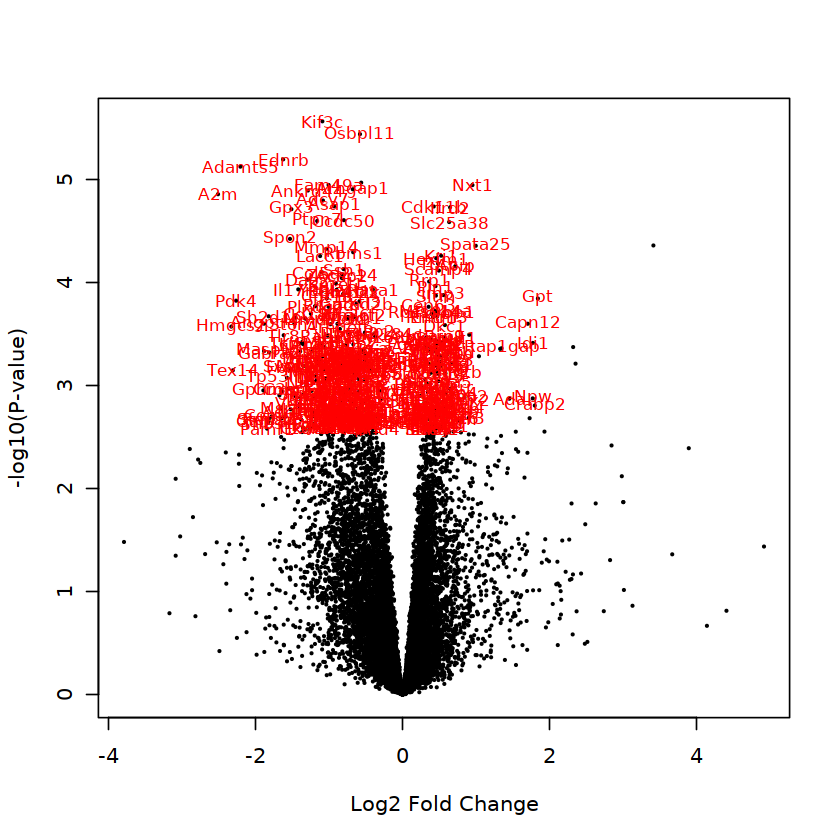

      ensembl_gene_id external_gene_name  logFC adj.P.Val
1  ENSRNOG00000037770     AABR07039936.1 -1.430     0.099
2  ENSRNOG00000045583     AABR07002068.1 -1.556     0.099
3  ENSRNOG00000031202            Trim30c -1.692     0.099
4  ENSRNOG00000000378     AABR07044914.1 -1.698     0.099
5  ENSRNOG00000057430     AABR07039694.1 -1.748     0.099
6  ENSRNOG00000042471         RGD1560324 -1.872     0.099
7  ENSRNOG00000049434     AABR07001048.1 -1.912     0.099
8  ENSRNOG00000013624              Uevld -1.985     0.099
9  ENSRNOG00000059308     AABR07047750.2 -2.005     0.099
10 ENSRNOG00000057999     AABR07047744.1 -2.005     0.099
11 ENSRNOG00000058209     AABR07063893.1 -2.058     0.099
12 ENSRNOG00000007782               Ghrh -2.061     0.099
13 ENSRNOG00000051014     AABR07016418.1 -2.086     0.099
14 ENSRNOG00000059468     AABR07034573.3 -2.104     0.099
15 ENSRNOG00000061625     AABR07048698.1 -2.148     0.099
16 ENSRNOG00000053576         AC126530.2 -2.154     0.099
17 ENSRNOG0000

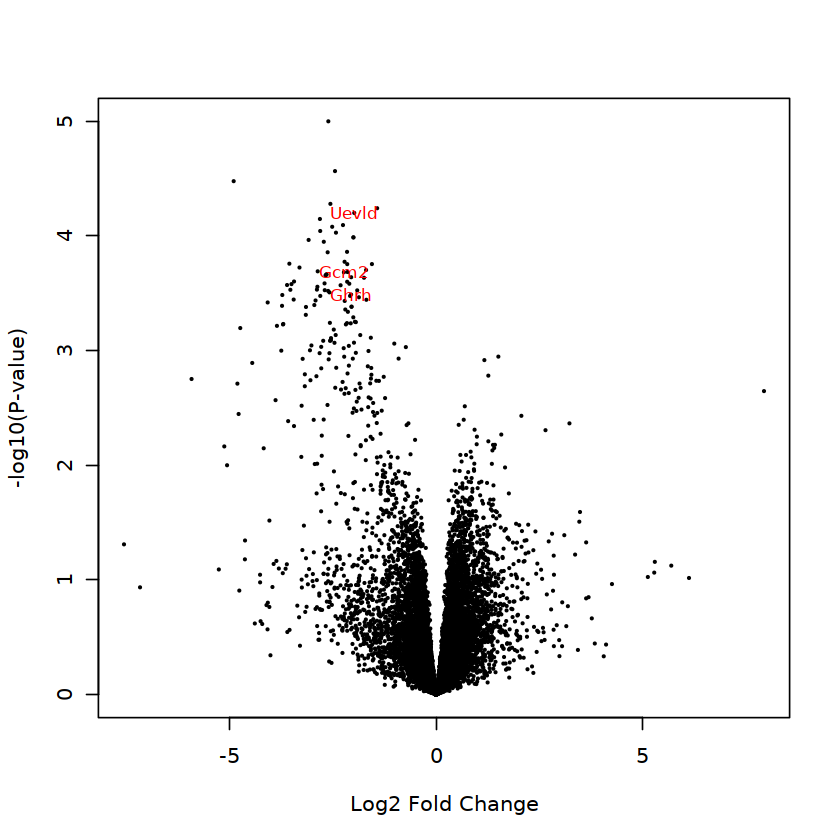

      ensembl_gene_id external_gene_name  logFC adj.P.Val
1  ENSRNOG00000018225           Tp53inp2  2.643     0.093
2  ENSRNOG00000052564               Gpx3  1.825     0.092
3  ENSRNOG00000010947              Mmp14  1.247     0.092
4  ENSRNOG00000015655             Ptgfrn  0.907     0.099
5  ENSRNOG00000012763            Cwf19l1 -0.614     0.099
6  ENSRNOG00000006559              Akap8 -0.661     0.093
7  ENSRNOG00000012558               Orc2 -0.717     0.077
8  ENSRNOG00000054157              Nadk2 -0.760     0.099
9  ENSRNOG00000014071               Ddb2 -0.815     0.093
10 ENSRNOG00000029466         RGD1562608 -0.844     0.099
11 ENSRNOG00000051623             Exosc8 -0.864     0.093
12 ENSRNOG00000039890            Abcg3l3 -1.052     0.077
13 ENSRNOG00000029022             Zfp112 -1.192     0.099
14 ENSRNOG00000036572              Sfxn4 -1.209     0.093
15 ENSRNOG00000011634               Xkr6 -1.249     0.093
16 ENSRNOG00000037658            Gprasp2 -1.270     0.093
17 ENSRNOG0000

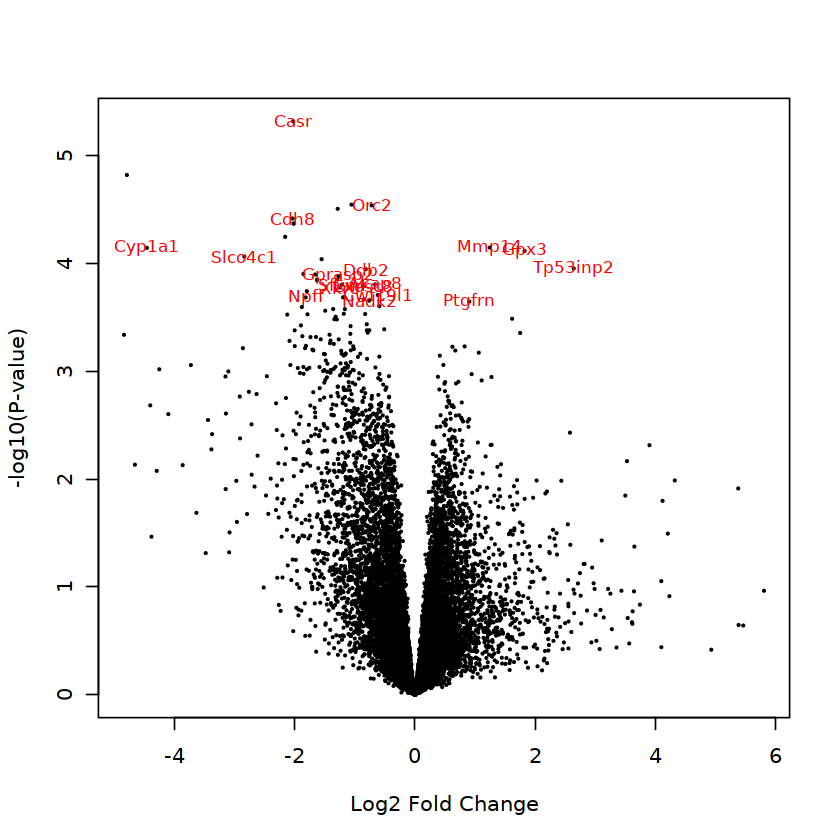

       ensembl_gene_id external_gene_name  logFC adj.P.Val
1   ENSRNOG00000028382              Rfxap  2.435     0.082
2   ENSRNOG00000061379                 C7  2.253     0.095
3   ENSRNOG00000006319              Cxcr6  1.686     0.093
4   ENSRNOG00000022764              Evi2a  1.378     0.097
5   ENSRNOG00000003357             Col3a1  1.336     0.096
6   ENSRNOG00000016695               Mmp2  1.263     0.092
7   ENSRNOG00000010045             Clec4a  1.252     0.096
8   ENSRNOG00000011947              Tifab  1.223     0.099
9   ENSRNOG00000014125              Evi2b  1.208     0.098
10  ENSRNOG00000010646           Tmem229b  1.111     0.097
11  ENSRNOG00000006778              Mmp19  1.061     0.097
12  ENSRNOG00000015971            Slc12a2  1.059     0.082
13  ENSRNOG00000012531              Ephb2  1.053     0.097
14  ENSRNOG00000009385             Pik3cg  1.035     0.082
15  ENSRNOG00000010947              Mmp14  1.009     0.082
16  ENSRNOG00000010918              Cebpa  0.908     0.0

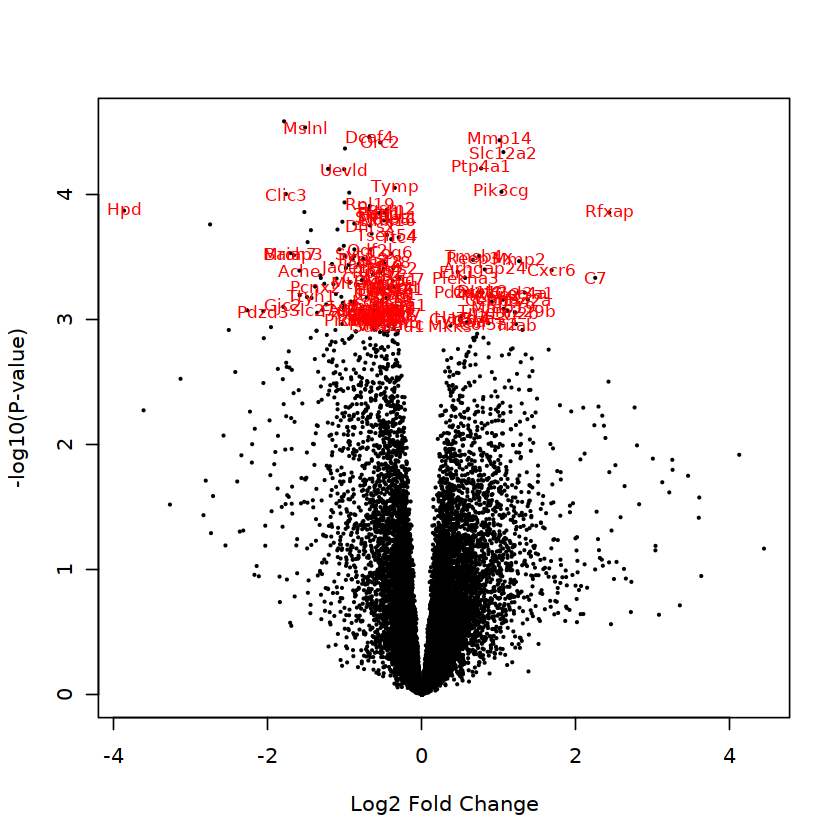

In [73]:
##native plots 
all.fite$names <- as_tibble(all.fite$coefficients, rownames="ensembl_gene_id") %>% 
                  left_join(., rhtx2gene) %>% 
                  dplyr::select(-human_ensembl_gene_id) %>% 
                  unique() %>% 
                  dplyr::select(external_gene_name) %>% 
                  unlist()       

pv1 <- function(f){
    if(f<0.1){
        return("Y")
    }
    else{
        return("N")
    }
}

cindVec <- c(1, 4, 6, 8)
contVec <- c("Diet_HFD_vs_NC", "Int_LIR_vs_RES", "nInt_LIR_vs_NO", "nInt_LIR_vs_RES")
deVec <- c(1:4)

for (x in 1:length(cindVec)){
    cl1 <- as_tibble(contrastList[[cindVec[x]]], rownames="rn") %>% dplyr::arrange(rn) %>% dplyr::mutate(HL = unlist(lapply(adj.P.Val, pv1))) %>% dplyr::select(rn, HL) %>% column_to_rownames("rn") %>% unlist()

    #pdf(paste0(OUTDIR, "/volcanoMAplot.", contVec[x], ".pdf"))
        volcanoplot(all.fite, coef = contVec[x], style = "p-value", highlight = dim(DEList[[deVec[x]]])[1], hl.col="red",
                xlab = "Log2 Fold Change", ylab = NULL, pch=16, cex=0.35, names=all.fite$names)
    print(DEList[[deVec[x]]])
#         plotMA(all.fite, coef = contVec[x], hl.col="red",
#            xlab = "Log2 Fold Change", pch=16, cex=0.35,
#            ylab = "Expression log-ratio", status=cl1)
#     dev.off()

}




In [74]:
##expression plots
dindVec <- c(1, 4, 6, 8)
dentList <- list(c("Diet","HFD","NC", "Tumour tissue; Diet: High Fat vs. Normal Chow", ""), 
                 c("Intervention", "LIR", "RES", "Tumour tissue; Intervention: Liraglutide vs. Restriction", ""), 
                 c("Intervention", "LIR", "NO", "Normal tissue; Intervention: Liraglutide vs. None", "n"), 
                 c("Intervention", "LIR", "RES", "Normal tissue; Intervention: Liraglutide vs. Restriction", "n"))
deVec <- c(1:4)
lapply(seq_along(deVec), function(x){
    tfive <- left_join(DEList[[x]], rhtx2gene) %>% na.omit() %>% head(5) %>% dplyr::select(ensembl_gene_id, external_gene_name)
    bfive <- left_join(DEList[[x]], rhtx2gene) %>% na.omit() %>% tail(5) %>% dplyr::select(ensembl_gene_id, external_gene_name)
    ggtfive <- plot_expression_so_tpm(so, genes=tfive[,1], mapgenes=tfive, conds=metadata, condcol=dentList[[x]][1], factors=c(dentList[[x]][2], dentList[[x]][3]), tag=paste0("Top 5; ", dentList[[x]][4]))
    ggsave(ggtfive, filename=paste0(OUTDIR, "/top5.", dentList[[x]][5], dentList[[x]][1],".",dentList[[x]][2], "_vs_", dentList[[x]][3], ".pdf"))
    ggbfive <- plot_expression_so_tpm(so, genes=bfive[,1], mapgenes=bfive, conds=metadata, condcol=dentList[[x]][1], factors=c(dentList[[x]][2], dentList[[x]][3]), tag=paste0("Bottom 5; ", dentList[[x]][4]))
    ggsave(ggbfive, filename=paste0(OUTDIR, "/bottom5.", dentList[[x]][5], dentList[[x]][1],".",dentList[[x]][2], "_vs_", dentList[[x]][3], ".pdf"))
})


Joining, by = c("ensembl_gene_id", "external_gene_name")
Joining, by = c("ensembl_gene_id", "external_gene_name")


[1] "Working on: ENSRNOG00000012390, ENSRNOG00000016690, ENSRNOG00000020389, ENSRNOG00000022101, ENSRNOG00000033915"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image



[1] "Working on: ENSRNOG00000009565, ENSRNOG00000019120, ENSRNOG00000023698, ENSRNOG00000028896, ENSRNOG00000057794"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Joining, by = c("ensembl_gene_id", "external_gene_name")
Joining, by = c("ensembl_gene_id", "external_gene_name")


[1] "Working on: ENSRNOG00000007782, ENSRNOG00000013624, ENSRNOG00000015008"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image



[1] "Working on: ENSRNOG00000007782, ENSRNOG00000013624, ENSRNOG00000015008"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image

Joining, by = c("ensembl_gene_id", "external_gene_name")
Joining, by = c("ensembl_gene_id", "external_gene_name")


[1] "Working on: ENSRNOG00000010947, ENSRNOG00000012763, ENSRNOG00000015655, ENSRNOG00000018225, ENSRNOG00000052564"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image



[1] "Working on: ENSRNOG00000002265, ENSRNOG00000019500, ENSRNOG00000022711, ENSRNOG00000047739, ENSRNOG00000056643"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image

Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”
Joining, by = c("ensembl_gene_id", "external_gene_name")
Joining, by = c("ensembl_gene_id", "external_gene_name")


[1] "Working on: ENSRNOG00000003357, ENSRNOG00000006319, ENSRNOG00000022764, ENSRNOG00000028382, ENSRNOG00000061379"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image



[1] "Working on: ENSRNOG00000001338, ENSRNOG00000008526, ENSRNOG00000015184, ENSRNOG00000038328, ENSRNOG00000058870"


No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Saving 6.67 x 6.67 in image

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

,ContrastsHFD.Any,ContrastsHFD.No,ContrastsNC.No,BatchF18FTSEUHT1008_RATetsE
1,0,0,1,1
2,0,0,1,1
3,0,0,1,1
4,0,0,1,1
5,0,0,1,1
6,0,0,1,1


In [159]:
##limma-voom including duplicateCorrelation as multiple Individuals have several replicates
OUTPUT <- paste0(RDATADIR, "/limma-voom.DGEList-NOTcorfit.RData")
#if(!file.exists(OUTPUT)){
    
    ##samples without cancer, with or withour any intervention
    indiv_with_cancer <- metadata %>% dplyr::filter(Tissue %in% "Tumour") %>% 
                                      dplyr::select(Individual) %>% 
                                      distinct() %>% 
                                      arrange(Individual) %>% 
                                      unlist()
    iwc_func <- function(f){
        unlist(lapply(f,function(ff){
        if(ff %in% indiv_with_cancer){return("Yes")}
        else{return("No")}}))
    }
    intany_func <- function(f){
        unlist(lapply(f,function(ff){
        if(ff %in% "NO"){return("No")}
        else{return("Any")}}))
    }

    conds_any <- metadata %>% dplyr::mutate(Ever_Tumour = iwc_func(Individual)) %>% 
                                  dplyr::mutate(Int_Any = intany_func(Intervention)) %>% 
                                  dplyr::select(sample, Individual, Tissue, Intervention, Ever_Tumour, Int_Any, Diet, Batch) %>% 
                                  as.data.frame()

    conds_any[] <- lapply(conds_any, factor)
    
    ##make input model.matrix design
    mmdf_any <- data.frame(Contrasts=paste(conds_any$Tissue, conds_any$Diet, conds_any$Int_Any, sep="."),
                           Batch=conds_any$Batch)
    ncf.design <- model.matrix(~0 + Contrasts + Batch, data = mmdf_any)
    colnames(ncf.design) <- c(levels(mmdf_any$Contrasts), "Batch")
    
    ##make DGEList from filtered counts
    ncf.dge <- DGEList(counts=obs_norm_filt2_df)
    ncf.keep <- filterByExpr(ncf.dge, 
                             ncf.design)
    ncf.dge <- ncf.dge[ncf.keep, 
                       keep.lib.sizes=FALSE]
    ncf.dge <- calcNormFactors(ncf.dge, 
                               method="TMM")
    
    ##voom
    ncf.voom <- voom(ncf.dge, 
                     ncf.design) 
    
    ##fit
    ncf.fit <- lmFit(ncf.voom, 
                     ncf.design)
    
    save(mmdf, ncf.design, ncf.voom, ncf.fit, file=OUTPUT)
# }
# if(file.exists(OUTPUT)){
#     load(OUTPUT)
# }

In [160]:
ncf.design

,Normal.HFD.Any,Normal.HFD.No,Normal.NC.No,Tumour.HFD.Any,Tumour.HFD.No,Tumour.NC.No,Batch
1,0,0,1,0,0,0,1
2,0,0,0,0,0,1,1
3,0,0,0,0,0,1,1
4,0,0,1,0,0,0,1
5,0,0,1,0,0,0,1
6,0,0,0,0,0,1,1
7,0,0,0,0,0,1,1
8,0,0,0,0,0,1,1
9,0,0,0,0,0,1,1
10,0,0,0,0,0,1,1


In [161]:
OUTPUT <- paste0(RDATADIR, "/limma-voom.contrastOut.NOTcorfit.RData")
#if(!file.exists(OUTPUT)){

    ncf.cont.matrix <- makeContrasts(
        ANY_vs_NO=Tumour.HFD.Any-Tumour.HFD.No,
        levels=ncf.design)
    ncf.fit2 <- contrasts.fit(ncf.fit, ncf.cont.matrix)
    ncf.fite <- eBayes(ncf.fit2, robust=TRUE)
    ncf.contrastOut <- topTable(ncf.fite, number=Inf, coef="ANY_vs_NO")
    
    ncf.contrastSig <- as_tibble(ncf.contrastOut, rownames="ensembl_gene_id") %>% 
                       inner_join(rhtx2gene,.) %>% 
                       dplyr::filter(adj.P.Val < 0.1) %>%
                       dplyr::select(ensembl_gene_id, external_gene_name, human_external_gene_name, human_ensembl_gene_id, logFC, adj.P.Val) %>%
                       dplyr::mutate_if(is.numeric, round, 3) %>%
                       dplyr::arrange(desc(logFC))

    save(ncf.contrastOut, ncf.contrastSig, ncf.fit2, ncf.fite, file=OUTPUT)

# }
# if(file.exists(OUTPUT)){
#     load(OUTPUT)
# }
# dim(contrastSig)

Joining, by = "ensembl_gene_id"


In [163]:
ncf.contrastOut %>% dplyr::filter(adj.P.Val < 0.5)

logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.776600,5.642303,4.510995,3.01012e-05,0.4358654,1.5518706
2.833444,6.262210,4.303574,6.23330e-05,0.4512909,0.9744198


Joining, by = "ensembl_gene_id"


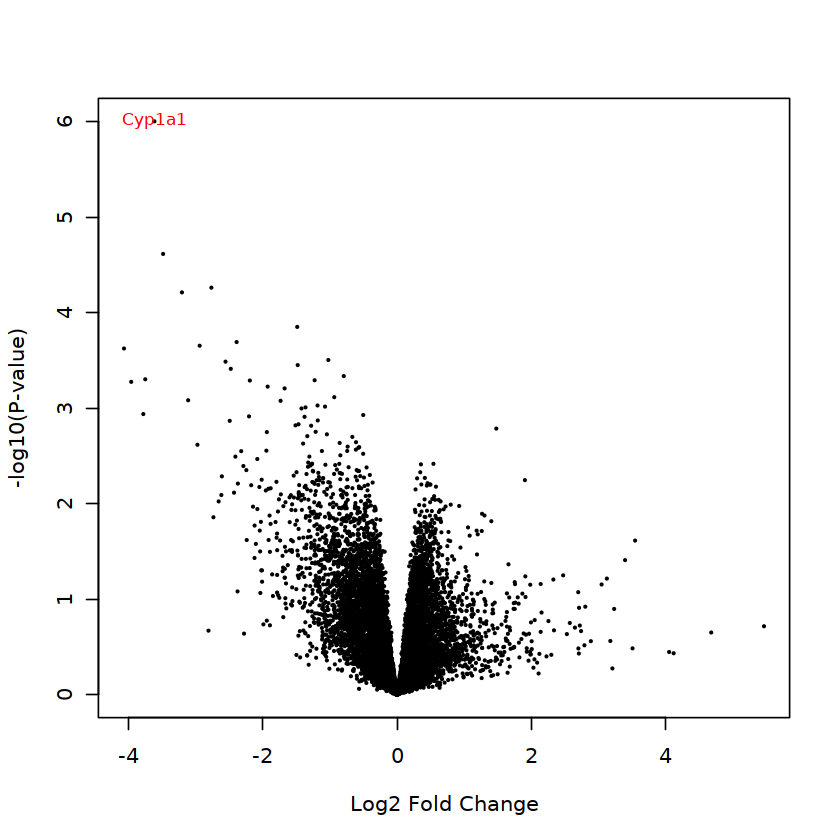

In [150]:
#volcanoplot HFD vs. INT
ncf.fite$names <- as_tibble(ncf.fite$coefficients, rownames="ensembl_gene_id") %>% 
                  left_join(., rhtx2gene) %>% 
                  dplyr::select(-human_ensembl_gene_id) %>% 
                  unique() %>% 
                  dplyr::select(external_gene_name) %>% 
                  unlist()    

#pdf(paste0(OUTDIR, "/volcanoMAplot.no_corfit.HFD_ANYINT_vs_NOINT.pdf"))
volcanoplot(ncf.fite, coef = 1, 
            style = "p-value", hl.col="red",
            highlight = dim(ncf.contrastSig)[1], 
            xlab = "Log2 Fold Change", ylab = NULL, 
            pch=16, cex=0.35, names=ncf.fite$names)

In [148]:
##limma-voom including duplicateCorrelation as multiple Individuals have several replicates
OUTPUT <- paste0(RDATADIR, "/limma-voom.DGEList-corfit.int_any-ever_tumour.RData")
#if(!file.exists(OUTPUT)){
    
    ##samples without cancer, with or withour any intervention
    indiv_with_cancer <- metadata %>% dplyr::filter(Tissue %in% "Tumour") %>% 
                                      dplyr::select(Individual) %>% 
                                      distinct() %>% 
                                      arrange(Individual) %>% 
                                      unlist()
    iwc_func <- function(f){
        unlist(lapply(f,function(ff){
        if(ff %in% indiv_with_cancer){return("Yes")}
        else{return("No")}}))
    }
    intany_func <- function(f){
        unlist(lapply(f,function(ff){
        if(ff %in% "NO"){return("No")}
        else{return("Any")}}))
    }

    conds_any <- metadata %>% dplyr::mutate(Ever_Tumour = iwc_func(Individual)) %>% 
                              dplyr::mutate(Int_Any = intany_func(Intervention)) %>% 
                              dplyr::select(sample, Individual, Tissue, Intervention, Ever_Tumour, Int_Any, Diet, Batch) %>% 
                              as.data.frame()

    conds_any[] <- lapply(conds_any, factor)
    any.design <- model.matrix(~0 + Contrasts + Batch, data = mmdf_any)
    colnames(any.design) <- c(levels(mmdf_any$Contrasts), "Batch")

    ##make DGEList from filtered counts
    any.dge <- DGEList(counts=obs_norm_filt2_df)
    any.keep <- filterByExpr(any.dge, 
                             any.design)
    any.dge <- any.dge[any.keep, 
                       keep.lib.sizes=FALSE]
    any.dge <- calcNormFactors(any.dge, 
                               method="TMM")
    
    ##voom, with 2 rounds of dupcor
    any.voom <- voom(any.dge, 
                     any.design, 
                     plot = FALSE)
    any.cor <- duplicateCorrelation(any.voom, 
                                    block = conds_any$Individual)
    print(paste0("Duplicate correlation 1: ", any.cor$consensus.correlation))
    any.voom1 <- voom(any.dge, 
                      any.design, 
                      plot = FALSE, 
                      correlation = any.cor$consensus.correlation, block=conds_any$Individual)
    any.cor1 <- duplicateCorrelation(any.voom1, 
                                     block = conds_any$Individual)
    print(paste0("Duplicate correlation 2: ", any.cor1$consensus.correlation))

    ##fit
    any.fit <- lmFit(any.voom1, 
                     any.design, 
                     block = conds_any$Individual, 
                     correlation = any.cor1$consensus.correlation)
    
    save(mmdf_any, any.design, any.voom1, any.cor1, any.fit, file=OUTPUT)
# }
# if(file.exists(OUTPUT)){
#     load(OUTPUT)
# }

[1] "Duplicate correlation 1: 0.104264426964247"
[1] "Duplicate correlation 2: 0.104252271124725"


In [151]:
OUTPUT <- paste0(RDATADIR, "/limma-voom.contrastOut.int_any-ever_tumour.RData")
#if(!file.exists(OUTPUT)){

    any.cont.matrix <- makeContrasts(
        ANY_vs_NO=HFD.Any-HFD.No,
        levels=any.design)
    any.fit2 <- contrasts.fit(any.fit, any.cont.matrix)
    any.fite <- eBayes(any.fit2, robust=TRUE)
    any.contrastOut <- topTable(any.fite, number=Inf, coef="ANY_vs_NO")
    
    any.contrastSig <- as_tibble(any.contrastOut, rownames="ensembl_gene_id") %>% 
                       inner_join(rhtx2gene,.) %>% 
                       dplyr::filter(adj.P.Val < 0.1) %>%
                       dplyr::select(ensembl_gene_id, external_gene_name, human_external_gene_name, human_ensembl_gene_id, logFC, adj.P.Val) %>%
                       dplyr::mutate_if(is.numeric, round, 3) %>%
                       dplyr::arrange(desc(logFC))

    save(any.contrastOut, any.contrastSig, any.fit2, any.fite, file=OUTPUT)

# }
# if(file.exists(OUTPUT)){
#     load(OUTPUT)
# }
# dim(contrastSig)

Joining, by = "ensembl_gene_id"


Joining, by = "ensembl_gene_id"


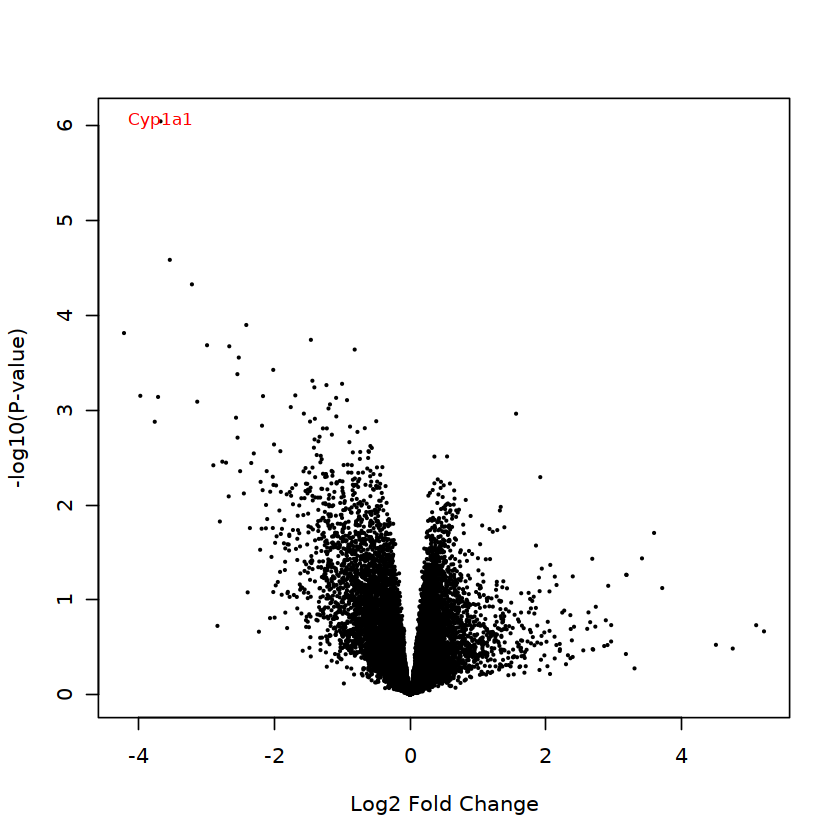

In [152]:
#volcanoplot HFD vs. INT
any.fite$names <- as_tibble(any.fite$coefficients, rownames="ensembl_gene_id") %>% 
                  left_join(., rhtx2gene) %>% 
                  dplyr::select(-human_ensembl_gene_id) %>% 
                  unique() %>% 
                  dplyr::select(external_gene_name) %>% 
                  unlist()    

#pdf(paste0(OUTDIR, "/volcanoMAplot.no_corfit.HFD_ANYINT_vs_NOINT.pdf"))
volcanoplot(any.fite, coef = 1, 
            style = "p-value", hl.col="red",
            highlight = dim(any.contrastSig)[1], 
            xlab = "Log2 Fold Change", ylab = NULL, 
            pch=16, cex=0.35, names=ncf.fite$names)

In [94]:
head(ncf.fite$coefficients)

,HFD_vs_ANY
ENSRNOG00000000001,-0.1785533
ENSRNOG00000000007,0.9859698
ENSRNOG00000000010,-0.1340235
ENSRNOG00000000017,1.1444029
ENSRNOG00000000021,0.3120529
ENSRNOG00000000024,-0.2212765


In [80]:
##limma-voom including duplicateCorrelation as multiple Individuals have several replicates
OUTPUT <- paste0(RDATADIR, "/limma-voom.DGEList-NOTcorfit.RData")
if(!file.exists(OUTPUT)){
    
    ##make input model.matrix design
    mmdf <- data.frame(Contrasts=conds_any$Int_Any)
    all.design <- model.matrix(~0 + Contrasts, data = mmdf)
    colnames(all.design) <- c(levels(mmdf$Contrasts))
    
    ##make DGEList from filtered counts
    all.dge <- DGEList(counts=obs_norm_filt2_df)
    all.keep <- filterByExpr(all.dge, 
                             all.design)
    all.dge <- all.dge[all.keep, 
                       keep.lib.sizes=FALSE]
    all.dge <- calcNormFactors(all.dge, 
                               method="TMM")
    
    ##voom, with 2 rounds of dupcor
    all.voom <- voom(all.dge, 
                     all.design) 
    
    ##fit
    all.fit <- lmFit(all.voom, 
                     all.design)
    
    save(mmdf, all.design, all.voom, all.fit, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


ERROR: Error in data.frame(Contrasts = conds_any$Int_Any): object 'conds_any' not found


In [82]:
conds_any <- metadata %>% dplyr::mutate(ever_tumour = iwc_func(Individual)) %>% 
                 dplyr::mutate(int_any = intany_func(Intervention)) %>% 
                 dplyr::select(sample, Individual, Tissue, Intervention, ever_tumour, int_any, Diet, Batch) %>% 
                 as.data.frame() 
    conds_any[] <- lapply(conds_any, factor)

ERROR: Error in iwc_func(Individual): could not find function "iwc_func"


In [37]:
##contrasts applied to tumour, normal across desired comparisons
OUTPUT <- paste0(RDATADIR, "/limma-voom.contrastOut.int_any-ever_tumour.RData")
if(!file.exists(OUTPUT)){
     cont.matrix <- makeContrasts(
        True_Normal_No_vs_Any=HFD.Any.No-HFD.No.No,
        levels=all.design.any)
    all.fit2 <- contrasts.fit(all.fit, cont.matrix)
    all.fite <- eBayes(all.fit2, robust=TRUE)
    contrastOut <- topTable(all.fite, number=Inf, coef="True_Normal_No_vs_Any")
    save(cont.matrix, all.fit2, all.fite, all.cor1, contrastOut, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [38]:
contrastOut[contrastOut$logFC < -4,]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSRNOG00000015637,-4.413907,2.702716,-3.451944,1.020612e-03,0.7399815,-3.951286
ENSRNOG00000007778,-4.096211,2.895613,-3.000963,3.904354e-03,0.7399815,-4.211652
ENSRNOG00000043445,-4.033108,2.330534,-2.729840,8.284981e-03,0.7399815,-4.226827
ENSRNOG00000019500,-4.062298,-1.357275,-4.280602,6.749359e-05,0.7399815,-4.357056


In [40]:
conds_any %>% dplyr::filter(ever_tumour %in% "No", Intervention %in% "LIR")


ERROR: Error in eval(lhs, parent, parent): object 'conds_any' not found


In [61]:
volcanoMAplotList[[1]]

[[1]]
NULL

[[2]]
NULL